In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, root_mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
data = pd.read_csv('LoanTapData.csv')

In [4]:
row,col = data.shape[0], data.shape[1]
data.head()


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [19]:

data = data.drop(columns=['issue_d', 'emp_title','dti','address','application_type','initial_list_status','earliest_cr_line',
                          'open_acc','pub_rec','revol_bal','revol_util','total_acc','grade','sub_grade'],axis=1)

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. Shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 0 rows and 14 columns. Shape of data is (396030, 13)


In [20]:
# Initial exploration
print("Initial data shape:", data.shape)
print("Missing values per column:\n", data.isnull().sum())
print("Data types:\n", data.dtypes)

row,col = data.shape[0],data.shape[1]

Initial data shape: (396030, 13)
Missing values per column:
 loan_amnt                   0
term                        0
int_rate                    0
installment                 0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
title                    1756
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64
Data types:
 loan_amnt               float64
term                     object
int_rate                float64
installment             float64
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
title                    object
mort_acc                float64
pub_rec_bankruptcies    float64
dtype: object


In [21]:
data.head(5)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,mort_acc,pub_rec_bankruptcies
0,10000.0,36 months,11.44,329.48,10+ years,RENT,117000.0,Not Verified,Fully Paid,vacation,Vacation,0.0,0.0
1,8000.0,36 months,11.99,265.68,4 years,MORTGAGE,65000.0,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,3.0,0.0
2,15600.0,36 months,10.49,506.97,< 1 year,RENT,43057.0,Source Verified,Fully Paid,credit_card,Credit card refinancing,0.0,0.0
3,7200.0,36 months,6.49,220.65,6 years,RENT,54000.0,Not Verified,Fully Paid,credit_card,Credit card refinancing,0.0,0.0
4,24375.0,60 months,17.27,609.33,9 years,MORTGAGE,55000.0,Verified,Charged Off,credit_card,Credit Card Refinance,1.0,0.0


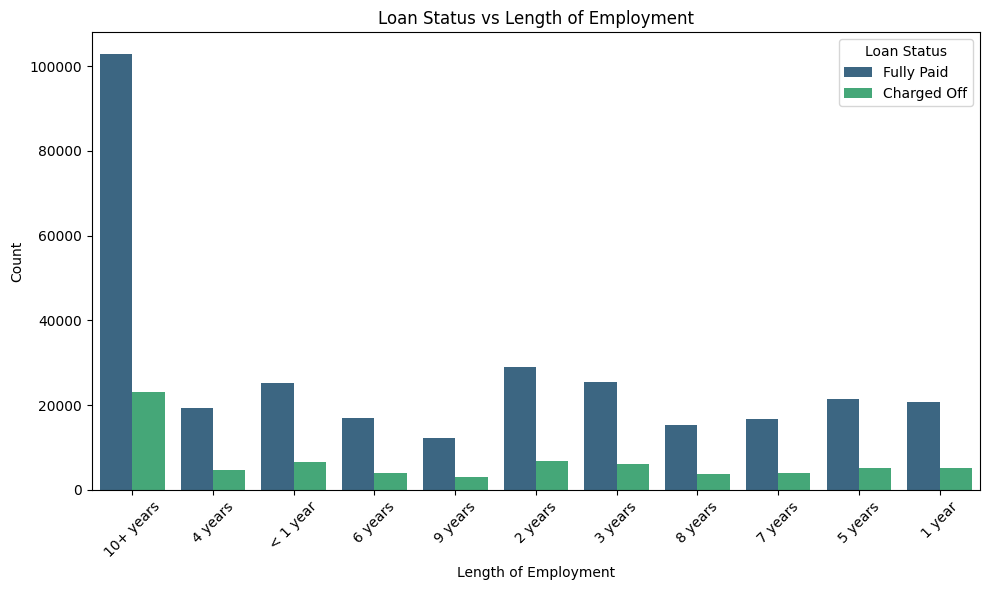

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'length_of_employment' is a categorical variable
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='emp_length', hue='loan_status', palette='viridis')
plt.title('Loan Status vs Length of Employment')
plt.xlabel('Length of Employment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status', loc='upper right')
plt.tight_layout()
plt.show()


In [23]:
# Count the number of missing values in each column
missing_values = data.isna().sum()

# Display the count of missing values
print("Missing values count in each column:")
missing_values

Missing values count in each column:


loan_amnt                   0
term                        0
int_rate                    0
installment                 0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
title                    1756
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [24]:
# Convert 'term' column to numeric safely
# Remove non-numeric characters and convert to float
data['term'] = data['term'].str.extract(r'(\d+)')  # Extract only the digits
data['term'] = pd.to_numeric(data['term'], errors='coerce')  # Coerce errors to NaN for safety

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. Shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 0 rows and 0 columns. Shape of data is (396030, 13)


In [25]:
# Handle missing values in 'term' column after conversion
data['term'] = data['term'].fillna(data['term'].median())

In [26]:
# Encode categorical variables
label_enc = LabelEncoder()
for col in ['home_ownership', 'verification_status', 'purpose', 'loan_status']:
    data[col] = label_enc.fit_transform(data[col])

# Handle missing values
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

In [27]:
data

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,mort_acc,pub_rec_bankruptcies
0,10000.0,36,11.44,329.48,10+ years,5,117000.0,0,1,12,Vacation,0.0,0.0
1,8000.0,36,11.99,265.68,4 years,1,65000.0,0,1,2,Debt consolidation,3.0,0.0
2,15600.0,36,10.49,506.97,< 1 year,5,43057.0,1,1,1,Credit card refinancing,0.0,0.0
3,7200.0,36,6.49,220.65,6 years,5,54000.0,0,1,1,Credit card refinancing,0.0,0.0
4,24375.0,60,17.27,609.33,9 years,1,55000.0,2,0,1,Credit Card Refinance,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60,10.99,217.38,2 years,5,40000.0,1,1,2,Debt consolidation,0.0,0.0
396026,21000.0,36,12.29,700.42,5 years,1,110000.0,1,1,2,Debt consolidation,1.0,0.0
396027,5000.0,36,9.99,161.32,10+ years,5,56500.0,2,1,2,pay off credit cards,0.0,0.0
396028,21000.0,60,15.31,503.02,10+ years,1,64000.0,2,1,2,Loanforpayoff,5.0,0.0


In [28]:
# Ensure all columns for correlation matrix are numeric
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_data = data[numeric_cols]

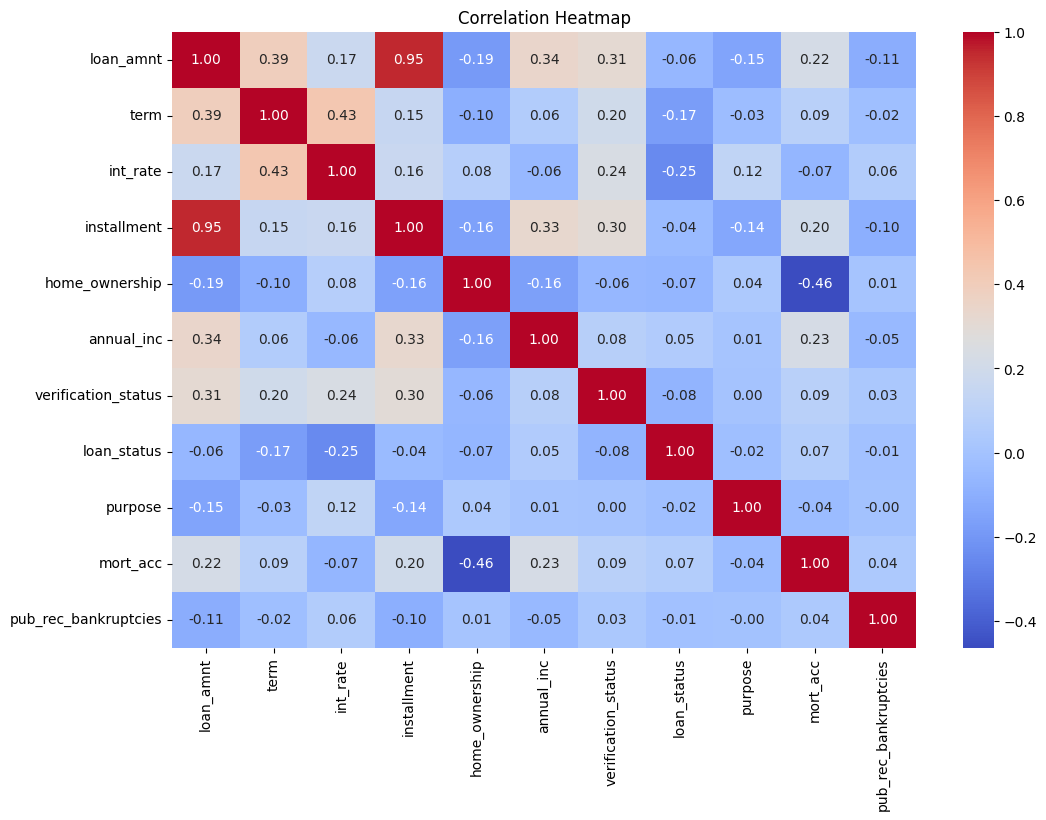

In [29]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [41]:
data = data.sample(10000, random_state=42)
# Feature and target separation
X = data.drop(columns=['loan_status'],axis=1)
y = data['loan_status']


##data.info()




In [42]:

# Ensure all features are numeric before splitting
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

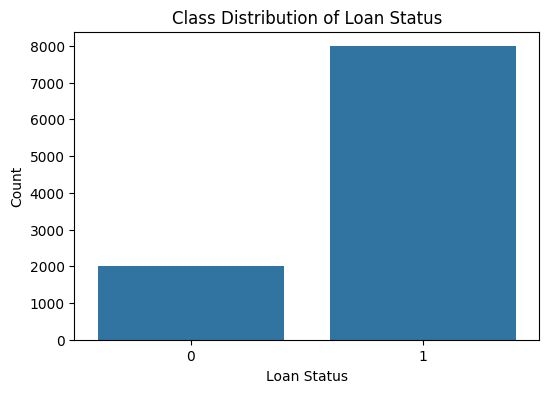

In [43]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

In [47]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    #'SVM': SVC()
}

    
    
# Train, evaluate, and optimize models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    results[name] = {
        'Accuracy': accuracy,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

Training Logistic Regression...
Logistic Regression Accuracy: 0.79
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.40      0.09      0.15       403
           1       0.81      0.96      0.88      1597

    accuracy                           0.79      2000
   macro avg       0.60      0.53      0.52      2000
weighted avg       0.73      0.79      0.73      2000

Training Decision Tree...
Decision Tree Accuracy: 0.72
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.29      0.28      0.28       403
           1       0.82      0.83      0.82      1597

    accuracy                           0.72      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.71      0.72      0.71      2000

Training Random Forest...
Random Forest Accuracy: 0.80
Classification Report for Random Forest:
              precision    recall  f1-sc

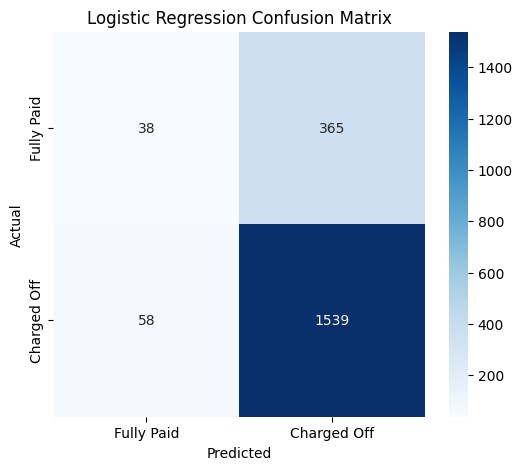

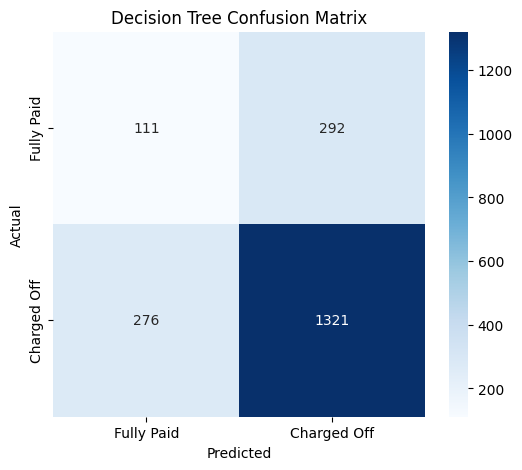

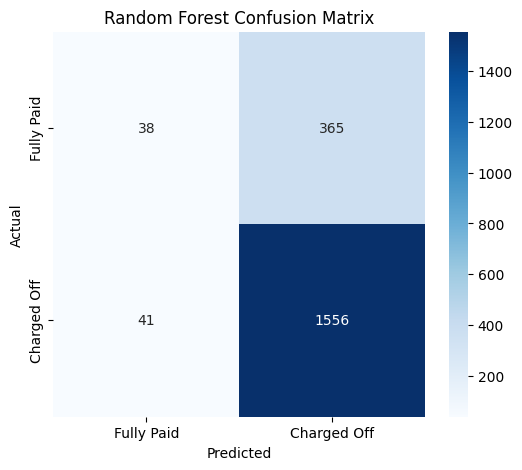

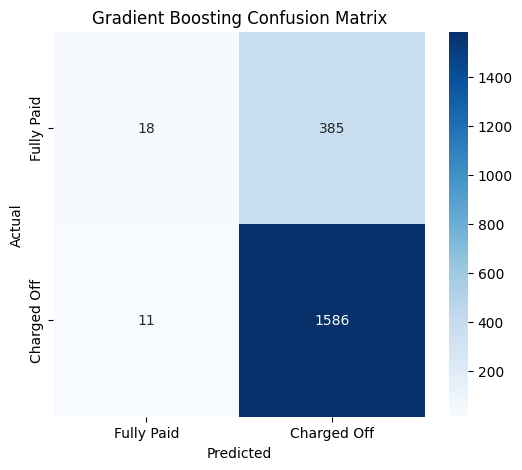

In [48]:
# Visualize Confusion Matrices
for name, metrics in results.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [49]:
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, f1_score
import numpy as np

# Enhanced evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    # Calculate additional metrics
    r2 = r2_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    rss = np.sum((y_true - y_pred) ** 2)
    fmeasure = f1_score(y_true, y_pred, average='weighted')
    
    # Sensitivity and specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)  # For binary classification
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Return the metrics
    return {
        'R2': r2,
        'Cohen\'s Kappa': cohen_kappa,
        'RMSE': rmse,
        'RSS': rss,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'F-Measure': fmeasure
    }

# Collect and display metrics for each model
for model_name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    metrics = evaluate_model(y_test, y_pred, model_name)
    
    # Display results
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
    print("-" * 50)


Model: Logistic Regression
R2: -0.3145
Cohen's Kappa: 0.0811
RMSE: 0.4599
RSS: 423.0000
Sensitivity: 0.9637
Specificity: 0.0943
F-Measure: 0.7327
--------------------------------------------------
Model: Decision Tree
R2: -0.7651
Cohen's Kappa: 0.1042
RMSE: 0.5329
RSS: 568.0000
Sensitivity: 0.8272
Specificity: 0.2754
F-Measure: 0.7138
--------------------------------------------------
Model: Random Forest
R2: -0.2617
Cohen's Kappa: 0.0981
RMSE: 0.4506
RSS: 406.0000
Sensitivity: 0.9743
Specificity: 0.0943
F-Measure: 0.7381
--------------------------------------------------
Model: Gradient Boosting
R2: -0.2306
Cohen's Kappa: 0.0578
RMSE: 0.4450
RSS: 396.0000
Sensitivity: 0.9931
Specificity: 0.0447
F-Measure: 0.7267
--------------------------------------------------


In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, classification_report, cohen_kappa_score,
    mean_squared_error, r2_score, confusion_matrix, f1_score, mean_absolute_percentage_error
)

# Initialize a results dictionary for DataFrame
comparison_results = []

# Evaluate models with additional metrics
for model_name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Basic Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Advanced Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Sensitivity and Specificity
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Append to results
    comparison_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Cohen Kappa': kappa,
        'RMSE': rmse,
        'R2': r2,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'MAPE': mape
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(comparison_results)

# Display the results DataFrame
results_df

,Model,Accuracy,F1 Score,Cohen Kappa,RMSE,R2,Sensitivity,Specificity,MAPE
0,Logistic Regression,0.7885,0.732713,0.081058,0.459891,-0.314499,0.963682,0.094293,8.219069e+14
1,Decision Tree,0.7160,0.713832,0.104156,0.532917,-0.765096,0.827176,0.275434,6.575255e+14
2,Random Forest,0.7970,0.738120,0.098104,0.450555,-0.261671,0.974327,0.094293,8.219069e+14
3,Gradient Boosting,0.8020,0.726669,0.057845,0.444972,-0.230595,0.993112,0.044665,8.669429e+14


In [51]:
 While[condition , NotebookEvaluate[First@Notebooks["Untitled-4"]]


SyntaxError: incomplete input (2917894878.py, line 1)